# Preliminary work

In [1]:
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.color
import skimage.filters
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import pandas as pd
import os
from matplotlib.patches import Rectangle 
from skimage.transform import resize
import matplotlib.image as mpimg

In [2]:
def create_bb_database(fig_flag = True, store_flag = True, sized_flag = True):
    
    # Works only with the data sent by James and Claire
    # (structure and file organisation)
    # THIS NEEDS TO BE DONE ONLY ONCE
    
    im_folders = ['TL1_Images_001_completed-20211101T225032Z-001\TL1_Images_001_completed', \
        'TL1_Images_002_completed-20211101T225019Z-001\TL1_Images_002_completed', \
        'TL1_Images_003_completed-20211101T225000Z-001\TL1_Images_003_completed', \
        'TL1_Images_004_completed-20211101T224942Z-001\TL1_Images_004_completed', \
        'TL1_Images_005_completed-20211101T224919Z-001\TL1_Images_005_completed', \
        'TL1_Images_006_completed-20211101T224858Z-001\TL1_Images_006_completed']

    bb_files = [im_folders[0]+'\labels_my-project-name_2021-10-27-06-32-35.csv', \
        im_folders[1]+'\labels_my-project-name_2021-10-27-11-03-59.csv', \
        im_folders[2]+'\labels_my-project-name_2021-10-28-01-24-54.csv', \
        im_folders[3]+'\labels_my-project-name_2021-10-27-02-06-20.csv', \
        im_folders[4]+'\labels_my-project-name_2021-10-28-04-54-35.csv', \
        im_folders[5]+'\labels_my-project-name_2021-10-27-03-40-39.csv']
    
    # Create a folder to store the database of clips
    if not(os.path.isdir('BirdClips')):
        os.mkdir('BirdClips')
        
    u = {'GL','GN','RG','SC','UN'} # labels
    
    if 'BB' in locals():
        del BB
    
    # Create subfolders to store the database of clips
    for d in u:
        if not(os.path.isdir('BirdClips/'+d)):
            os.mkdir('BirdClips/'+d)

    if fig_flag:
        k = 0
        plt.figure(figsize = (10,10))

    for i in range(len(bb_files)):
        
        bb_file = bb_files[i]
        im_folder = im_folders[i]
        bb = pd.read_csv(bb_file, header = None)
        bb = bb.to_numpy()
        print('Folder ',i+1, ' Bounding box count = ', len(bb))
        
        for j in range(len(bb)): # go through each BB
            label = bb[j,0]
            filename = im_folder + '/' + bb[j,5]
            im = cv2.imread(filename, cv2.IMREAD_COLOR)
            
            if sized_flag:
                # Crop a precpecified area
                width = 30; height = 30
                bb_centre = [bb[j,2]+bb[j,4]/2,bb[j,1]+bb[j,3]/2]
                row_start = np.round(np.max([1,bb_centre[0]-height/2])).astype(int)
                row_end = np.round(np.min([im.shape[0],row_start+height])).astype(int)
                col_start = np.round(np.max([1,bb_centre[1]-width/2])).astype(int)
                col_end = np.round(np.min([im.shape[1],col_start+width])).astype(int)                                 
                clip = im[row_start:row_end,col_start:col_end]
                clip = resize(clip,(width,height))
            else:
                clip = im[bb[j,2]:bb[j,2]+bb[j,4],bb[j,1]:bb[j,1]+bb[j,3]]
            
            
            if fig_flag:
                if j <= 4:
                    k = k + 1
                    plt.subplot(6,5,k)
                    plt.imshow(resize(clip, (50, 50)))
                    plt.axis('Off')
            if store_flag:
                to_save = 'BirdClips/' + label + '/clip_' + str(i+1) + '_' + str(j+1)+'_'+bb[j,5]
                mpimg.imsave(to_save, clip)
                bb[j,5] = filename
                if 'Clip_files' in locals(): 
                    Clip_files.append(to_save)
                else:
                    Clip_files = [to_save]
                

        if store_flag:
            if 'BB' in locals(): # create one large file with all annotations
                BB = np.append(BB,bb,axis = 0)
            else:
                BB = bb
    
    
    # Remove an outlier
    outlier1 = np.where(BB[:,3]>150)
    BB = np.delete(BB,outlier1[0],axis = 0)  
    Clip_files = np.delete(Clip_files,outlier1[0],axis = 0)  

    
    if store_flag:
    # Save the Overall file with bounding boxes
        zz = pd.DataFrame (BB)
        zz.to_csv('Overall_BB.csv', header = False, index = False)
        Clip_files = np.array(Clip_files)
        vv = pd.DataFrame (np.reshape(Clip_files,(-1,1)))
        vv.to_csv('Clip_files.csv', header = False, index = False)

    if fig_flag:
        plt.show()

    

Folder  1  Bounding box count =  338
Folder  2  Bounding box count =  154
Folder  3  Bounding box count =  555
Folder  4  Bounding box count =  577
Folder  5  Bounding box count =  706
Folder  6  Bounding box count =  663


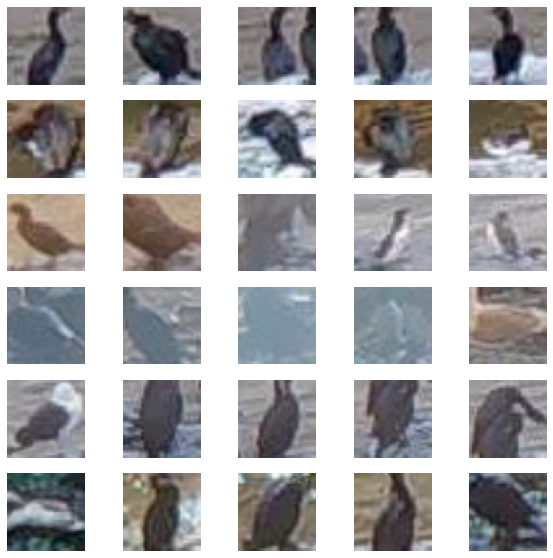

In [3]:
# Create database of clips, a single BB file, and a montage of the first 5 clips from each folder

create_bb_database(fig_flag = True, store_flag = True, sized_flag = True) # Needs to be done only once


Obviously, colour will be misleading for this type of data. Hence, we will use grey images only.

     Minx   Maxx   Avrx   Miny   Maxy   Avry   MinA   MaxA   AvrA   [Number]
----------------------------------------------------------------------------
GL     13     72     33     14     47     26    255   2340    865    308  

GN     34     34     34     25     25     25    850    850    850      1  

RG      5     53     14      6     49     19     60   1127    286    908  

SC      8     99     27      9     62     34    108   5060    979   1762  

UN     12     40     25     13     34     23    247   1190    621     13  

----------------------------------------------------------------------------
All     5     99     24      6     62     29     60   5060    755   2992  


Table note: x, y, Area


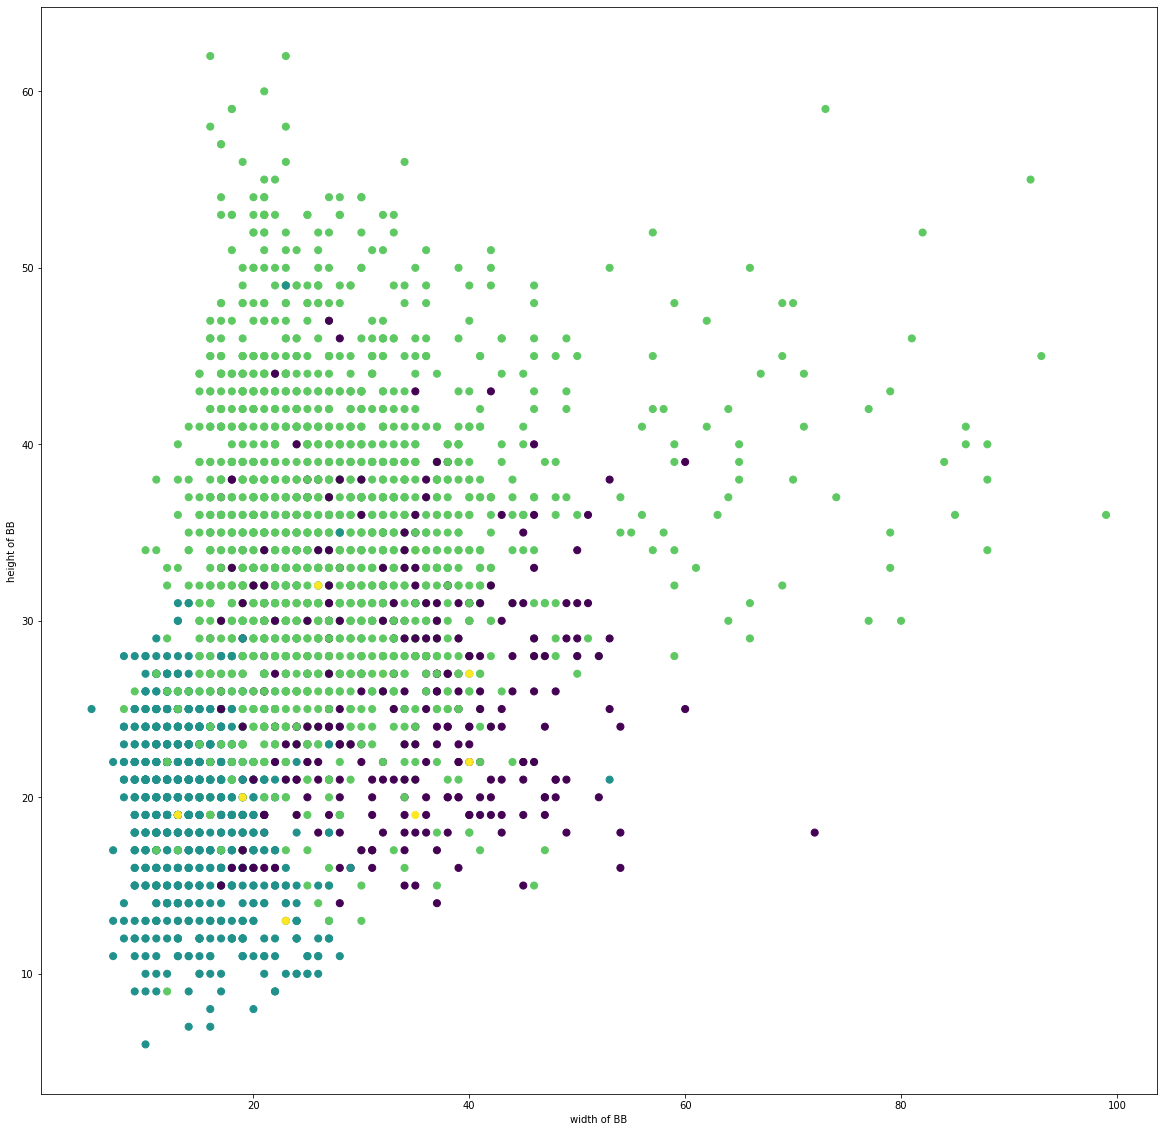

In [4]:
# Get some stats about the bounding boxes
BB = pd.read_csv('Overall_BB.csv', header = None)
BB = BB.to_numpy()

u = ['GL','GN','RG','SC','UN'] # labels
bb_sizes = np.zeros((len(u),10))

for i in range(len(u)):
    index = np.where(BB[:,0] == u[i]) # find all bounding boxes for this class label
    ar = BB[index,3]*BB[index,4]
    bb_sizes[i] = [np.min(BB[index,3]),np.max(BB[index,3]),np.mean(BB[index,3]), \
        np.min(BB[index,4]),np.max(BB[index,4]),np.mean(BB[index,4]), \
        np.min(ar),np.max(ar),np.mean(ar), len(index[0])]
    
    BB[index,0] = i # convert labels to numerical

ar = BB[:,3]*BB[:,4]
bb_total = [np.min(BB[:,3]),np.max(BB[:,3]),np.mean(BB[:,3]), \
    np.min(BB[:,4]),np.max(BB[:,4]),np.mean(BB[:,4]), \
    np.min(ar),np.max(ar),np.mean(ar),np.sum(bb_sizes[:,-1])]

print('     Minx   Maxx   Avrx   Miny   Maxy   Avry   MinA   MaxA   AvrA   [Number]')
print('----------------------------------------------------------------------------')
for i in range(len(u)):
    print('%2s ' % u[i], end =" ")
    for j in range(10):
        print('%5i ' % bb_sizes[i,j], end=" ")
    print('\n')
print('----------------------------------------------------------------------------')

print('All', end =" ")
for j in range(10):
    print('%5i ' % bb_total[j], end=" ")
print('\n')

print('\nTable note: x, y, Area')


plt.figure(figsize=(20,20))
plt.scatter(BB[:,3],BB[:,4],c = BB[:,0], s = 50)
plt.xlabel('width of BB')
plt.ylabel('height of BB')
plt.show()

Labels = BB[:,0] # needed for later
np.savetxt("Clip_labels.csv", Labels, delimiter=",")

Question here: How shall we decide on the size of the bounding boxes to check? Random match to the database? Average (class or overall?) Mode of the histogram? 

In [5]:
def choose_threshold(im):
    # Choose a valley between the two modes of the histogram. The histogram is bimodal: "water" and "island"
    # Smoothing function: savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
    
    grey_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    histogram,_ = np.histogram(grey_image.ravel(),256,[0,256])
    
    histogram = savgol_filter(histogram.ravel(), 71, 3) # window size 51, polynomial order 3
    histogram = savgol_filter(histogram.ravel(), 71, 3) # window size 51, polynomial order 3
    peaks,stats = find_peaks(histogram.ravel(), height = 0.3)
    z = stats["peak_heights"]
    peak1 = np.argmax(z)
    valleys,_ = find_peaks(-histogram.ravel(), -z[peak1])
    vs = valleys[valleys<peaks[peak1]]
    
    
    plt.figure()
    plt.subplot(121)
    plt.plot(histogram,'k-') 
    plt.plot(peaks,histogram[peaks], 'ko')
    plt.plot(peaks[peak1],histogram[peaks[peak1]],'ro', mfc = "none", mew = 0.8, ms = 12)
    plt.title('Histogram')
    
    plt.subplot(122)
    plt.plot(-histogram)
    plt.plot(valleys,-histogram[valleys],'bo')
    thr = vs[-1]
    plt.plot(thr,-histogram[thr],'bo', mfc = "none", mew = 0.8, ms = 12)
    plt.title('Threshold =' + str(thr))
 
    return thr

(400, 1600, 3)


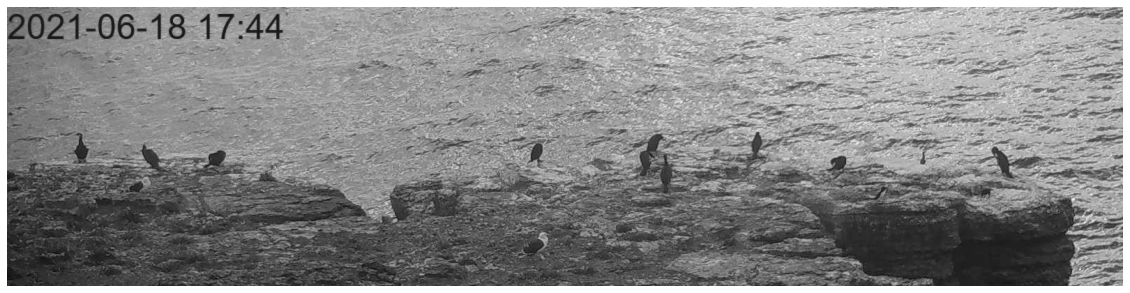

In [6]:
# Image manipulation

examplefile = 'SOS_PUF_2021_Camera1_202106181744.jpg'
examplefolder = 'TL1_Images_006_completed-20211101T224858Z-001/TL1_Images_006_completed/'
exampleim = cv2.imread(examplefolder+examplefile, cv2.IMREAD_COLOR)
print(exampleim.shape)
grey_image = cv2.cvtColor(exampleim, cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (20,10))
plt.imshow(grey_image, cmap="gray")
plt.axis('off')
plt.show()

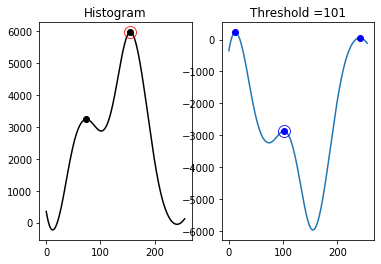

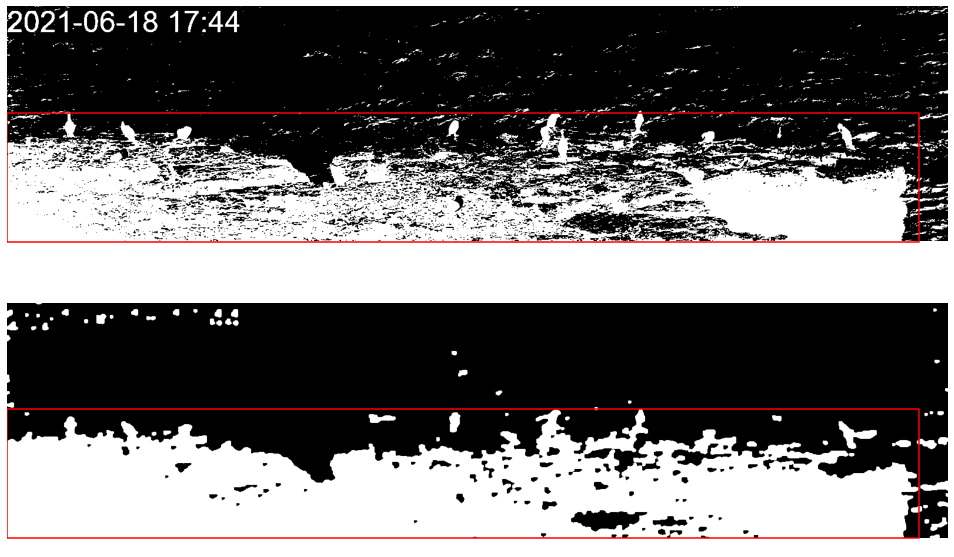

In [7]:
# Where shall we look for bounding boxes?
thr = choose_threshold(exampleim)
segmented = cv2.threshold(grey_image,thr, 255,cv2.THRESH_BINARY_INV)[1]

# Find both island and birds
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6), (2, 2))
island_and_birds_mask = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, element)
island_and_birds_mask = cv2.morphologyEx(island_and_birds_mask, cv2.MORPH_OPEN, element)
island_and_birds_mask = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, element)
island_and_birds_mask = cv2.morphologyEx(island_and_birds_mask, cv2.MORPH_OPEN, element)

nb_components_i, output_i, stats_i, centroids_i = cv2.connectedComponentsWithStats(island_and_birds_mask, connectivity=8)
# nb_components >>> number of components
# output >>> image with labels
# stats >>> [x,y,w,h,num_pixels]
# centroids >>>

# Find the component corresponding to the island - the second largest
index_largest = np.argmax(stats_i[:,-1])
stats_i[index_largest,-1] = 0 # mask the largest
index_island = np.argmax(stats_i[:,-1])
bb_island = stats_i[index_island,:]
x,y,w,h,sz = bb_island
xisland = [x,x+w,x+w,x,x] # plotting coordinates for the island bounding box
yisland = [y,y,y+h,y+h,y]
 
f, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].imshow(segmented, cmap="gray")
axs[0].axis('off')
axs[0].plot(xisland,yisland,'r-')
axs[1].imshow(island_and_birds_mask, cmap="gray")
axs[1].axis('off')
axs[1].plot(xisland,yisland,'r-')
plt.show()

# Prepare a data set

In [8]:
# Create the database of true BB (positives)

CF = pd.read_csv('Clip_files.csv', header = None)
CF = CF.to_numpy()

if 'Data' in locals():
    del Data

for i in range(len(CF)):
    im = cv2.imread(CF[i][0], cv2.IMREAD_COLOR) # read clip
    gim = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # convert to grey
    data_row = np.reshape(gim,(1,-1))
    
    # Create array Data
    # Labels have been created already in a cell above
    if 'Data' in locals(): 
        Data = np.append(Data,data_row,axis = 0)
    else:
        Data = data_row
        
print(Data.shape)
print(Labels.shape)


(2992, 900)
(2992,)


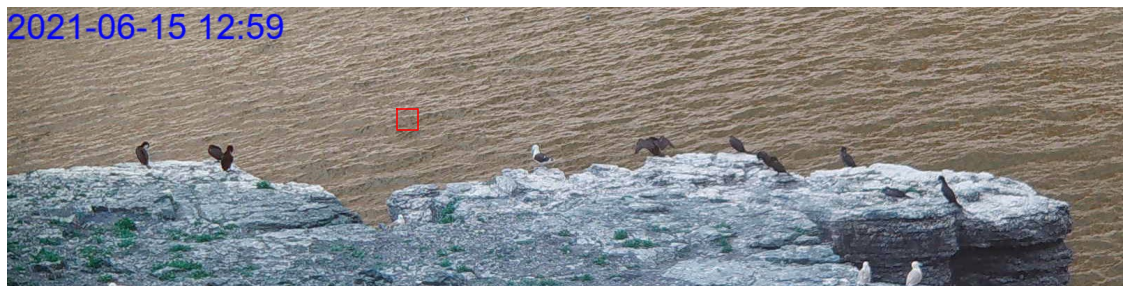

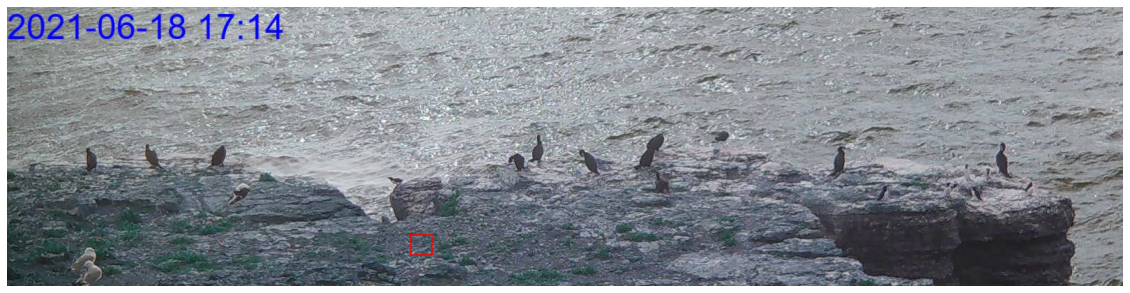

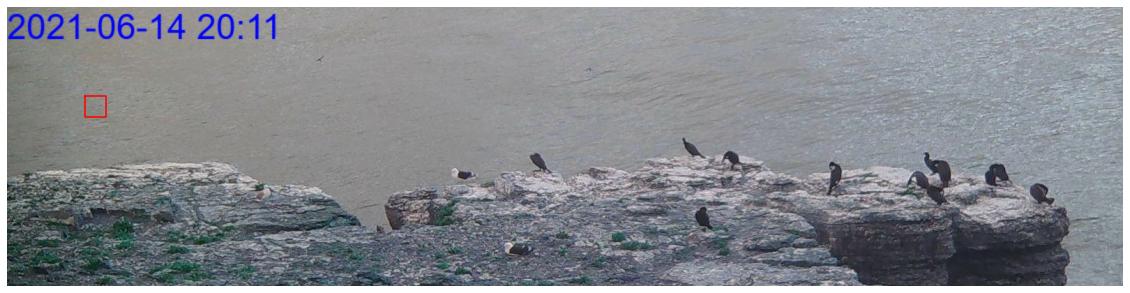

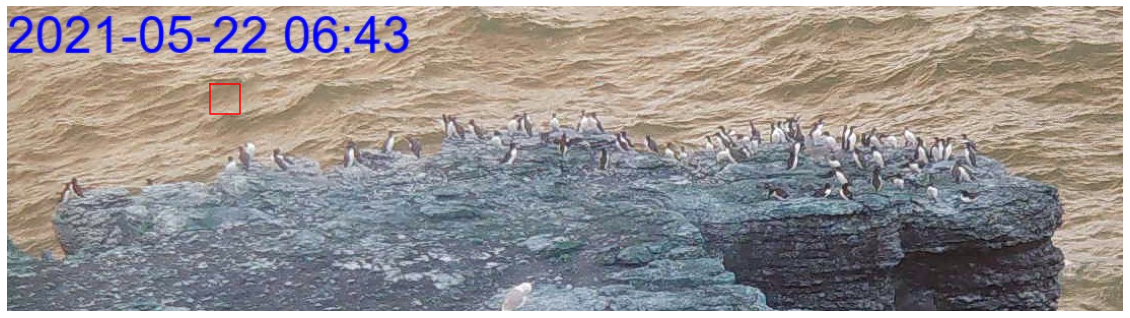

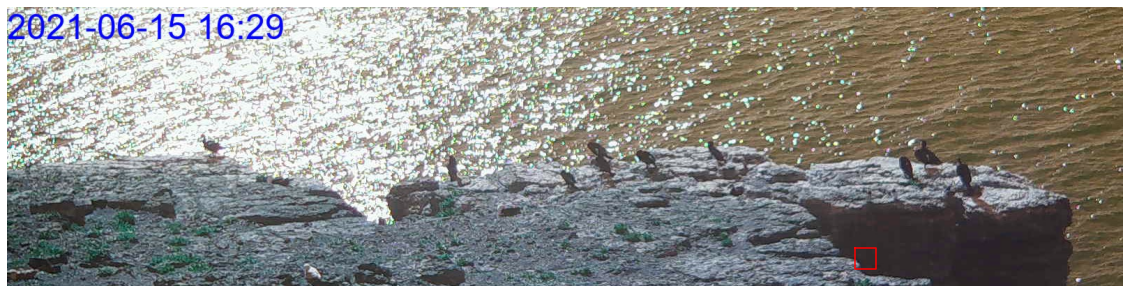

(8976, 900)
(8976,)


In [9]:
# Add random BBs (negatives)
N = len(Data)*2 # number of negatives

BB = pd.read_csv('Overall_BB.csv', header = None)
BB = BB.to_numpy()

# Here we use the bottom part (3/4) of the image for the negative examples.

# Crop a precpecified area
width = 30; height = 30

for i in range(N):
    
    # Pick a random image
    im_index = np.random.randint(len(BB), dtype=int)
  
    im = cv2.imread(BB[im_index,5], cv2.IMREAD_COLOR) # read clip
    
    # Pick a random point in the range of interest to be the centre of a negative example
    cx = np.random.randint(low = width/2, high = im.shape[1]-width/2, dtype=int)
    cy = np.random.randint(low = im.shape[0]*0.25+height/2, high = im.shape[0]-height/2, dtype=int)
    row_start = np.round(cy-height/2).astype(int)
    row_end = np.round(row_start+height).astype(int)
    col_start = np.round(cx-width/2).astype(int)
    col_end = np.round(col_start+width).astype(int)                                 
    neg_clip = im[row_start:row_end,col_start:col_end]

    if i <=4:
        plt.figure(figsize=(20,10))
        plt.imshow(im)
        plt.axis('Off')
        plt.plot([col_start,col_start,col_end,col_end,col_start],[row_start,row_end,row_end,row_start,row_start],'r-')
        plt.show()
    
    neg_gim = cv2.cvtColor(neg_clip, cv2.COLOR_RGB2GRAY) # convert to grey
    neg_data_row = np.reshape(neg_gim,(1,-1))

    Data = np.append(Data,neg_data_row,axis = 0)
    Labels = np.append(Labels,[9],axis = 0)

print(Data.shape)
print(Labels.shape)
    

In [21]:
# Reduce data dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components = 30)
DataPCA = pca.fit_transform(Data)

# Save the PCA-transformed data
ClipsPCA = np.hstack((DataPCA,np.reshape(Labels,(-1,1))))
np.savetxt("ClipsPCA30.csv", ClipsPCA, delimiter=",") 

#plt.figure(figsize=(20,20))
#plt.scatter(DataPCA[:,0],DataPCA[:,1],c = Labels, s = 12)
#plt.show()
